In [ ]:
import os
import shutil
import random
import sys
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
import glob
from skimage.feature import hog # for feature extraction
from sklearn.metrics import confusion_matrix
from mlxtend.plotting import plot_confusion_matrix
from tensorflow.keras.preprocessing import image as kimage
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Activation, BatchNormalization, ZeroPadding2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator, DirectoryIterator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
%matplotlib inline

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
Atelectasis_dir = "/content/drive/MyDrive/Data/Cardiomegaly/"
normal_dir = "/content/drive/MyDrive/Data/Normal/"

# CNN

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import glob
import cv2
from keras.models import Model, Sequential
from keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout
from keras.layers import Activation, Dropout, Flatten, Dense
from keras.layers import BatchNormalization
import os
from PIL import Image
import seaborn as sns
SIZE=224

In [ ]:
train_images = []
train_labels = []
for directory_path in glob.glob('/content/drive/MyDrive/Data/resized/train/*'):
    label = directory_path.split("/")[-1]
   # print(label)
    for img_path in glob.glob(os.path.join(directory_path, "*.png")):
        #print(img_path)
        img = cv2.imread(img_path)
        img = cv2.resize(img, (SIZE, SIZE))
        #img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        train_images.append(img)
        train_labels.append(label)
train_images = np.array(train_images)
train_labels = np.array(train_labels)

In [ ]:
# test
test_images = []
test_labels = []
for directory_path in glob.glob('/content/drive/MyDrive/Data/resized/test/*'):
    fruit_label = directory_path.split("/")[-1]
    #print(label)
    for img_path in glob.glob(os.path.join(directory_path, "*.png")):
        img = cv2.imread(img_path)
        img = cv2.resize(img, (SIZE, SIZE))
        #img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        test_images.append(img)
        test_labels.append(fruit_label)
test_images = np.array(test_images)
test_labels = np.array(test_labels)

In [ ]:
#Encode labels from text to integers.
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
le.fit(test_labels)
test_labels_encoded = le.transform(test_labels)
le.fit(train_labels)
train_labels_encoded = le.transform(train_labels)
#le.fit(valid_labels)
#valid_label_encoded = le.transform(valid_labels)

In [ ]:
#Split data into test and train datasets (already split but assigning to meaningful convention)
from sklearn.model_selection import train_test_split
x_train, y_train, x_test, y_test = train_images, train_labels_encoded, test_images, test_labels_encoded

In [ ]:
# Normalize pixel values to between 0 and 1
#x_train, x_test = x_train / 255.0, x_test / 255.0
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train = x_train / 255
x_test = x_test / 255

In [ ]:
from keras.utils import to_categorical
y_train_one_hot = to_categorical(y_train,2)
y_test_one_hot = to_categorical(y_test,2)

In [ ]:
from sklearn.model_selection import train_test_split
x_train,x_valid,train_label,valid_label = train_test_split(x_train, y_train_one_hot, test_size=0.1, random_state=5)

In [ ]:
print('x_train shape:', x_train.shape)
print('x_test shape:', x_test.shape)
#print('x_valid shape:', x_valid.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')
#print(x_valid.shape[0], 'test samples')

x_train shape: (3168, 224, 224, 3)
x_test shape: (880, 224, 224, 3)
3168 train samples
880 test samples


In [ ]:
# Find the unique numbers from the train labels
classes = np.unique(y_train)
nClasses = len(classes)
print('Total number of outputs : ', nClasses)
print('Output classes : ', classes)

Total number of outputs :  2
Output classes :  [0 1]


In [ ]:
x_train.shape,x_valid.shape,train_label.shape,valid_label.shape

((3168, 224, 224, 3), (352, 224, 224, 3), (3168, 2), (352, 2))

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models
def DenseNet169_5conv(input_shape=(224, 224, 3)):
    base_model = tf.keras.applications.DenseNet169(
        include_top=False,
        weights='imagenet',
        input_shape=input_shape,
        pooling=None,
    )
    # Freeze the pre-trained layers
    for layer in base_model.layers:
        layer.trainable = False

    model = models.Sequential()
    model.add(base_model)
    # Add five additional convolutional layers
    model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
    model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
    model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
    model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
    model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
    model.add(layers.GlobalAveragePooling2D())
    # Dense layers for classification
    model.add(layers.Dense(256, activation='relu'))
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(2, activation='sigmoid'))  # Binary classification
    return model

In [ ]:
# Create DenseNet169 with 5 Convolutional Layers model for binary classification
model = DenseNet169_5conv()
# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
# Print model summary
model.summary()

51877672/51877672 [==============================] - 1s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet169 (Functional)    (None, 7, 7, 1664)        12642880  
                                                                 
 conv2d (Conv2D)             (None, 7, 7, 64)          958528    
                                                                 
 conv2d_1 (Conv2D)           (None, 7, 7, 64)          36928     
                                                                 
 conv2d_2 (Conv2D)           (None, 7, 7, 64)          36928     
                                                                 
 conv2d_3 (Conv2D)           (None, 7, 7, 64)          36928     
                                                                 
 conv2d_4 (Conv2D)           (None, 7, 7, 64)          36928     
                                                         

In [ ]:
import datetime
start = datetime.datetime.now()
#Train the CNN model
history = model.fit(x_train, train_label, epochs=50,batch_size = 64, validation_data = (x_valid, valid_label))
end = datetime.datetime.now()
print("Total execution time is: ", end-start)

Epoch 1/50
50/50 [==============================] - 45s 427ms/step - loss: 0.1462 - accuracy: 0.9372 - val_loss: 0.0149 - val_accuracy: 0.9943
Epoch 2/50
50/50 [==============================] - 12s 243ms/step - loss: 0.0623 - accuracy: 0.9814 - val_loss: 0.0905 - val_accuracy: 0.9744
Epoch 3/50
50/50 [==============================] - 12s 248ms/step - loss: 0.0140 - accuracy: 0.9953 - val_loss: 0.0037 - val_accuracy: 0.9972
Epoch 4/50
50/50 [==============================] - 12s 250ms/step - loss: 0.0026 - accuracy: 0.9994 - val_loss: 3.9433e-05 - val_accuracy: 1.0000
Epoch 5/50
50/50 [==============================] - 13s 254ms/step - loss: 0.0021 - accuracy: 0.9994 - val_loss: 0.0290 - val_accuracy: 0.9943
Epoch 6/50
50/50 [==============================] - 13s 265ms/step - loss: 0.0122 - accuracy: 0.9959 - val_loss: 7.3175e-04 - val_accuracy: 1.0000
Epoch 7/50
50/50 [==============================] - 15s 295ms/step - loss: 4.5458e-04 - accuracy: 1.0000 - val_loss: 2.4650e-05 - val_

In [ ]:
#test_eval = feature_extractor.evaluate(x_test, y_test_one_hot, verbose=1)
score = model.evaluate(x_test, y_test_one_hot, verbose=1)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

28/28 [==============================] - 8s 284ms/step - loss: 0.0185 - accuracy: 0.9977
Test loss: 0.018497053533792496
Test accuracy: 0.9977272748947144


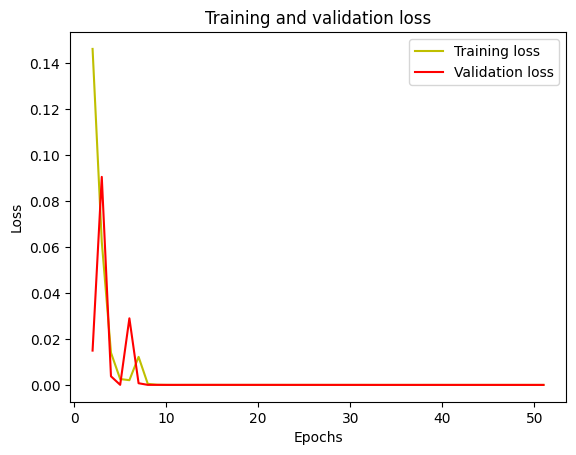

In [ ]:
#plot the training and validation accuracy and loss at each epoch
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(2, len(loss) + 2)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

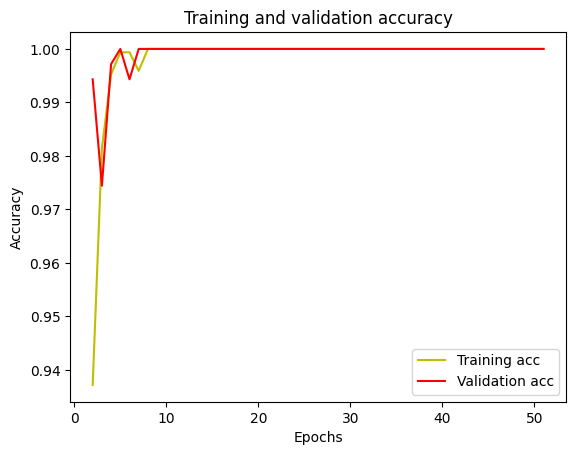

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
plt.plot(epochs, acc, 'y', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
#test_eval = feature_extractor.evaluate(x_test, y_test_one_hot, verbose=1)
score = model.evaluate(x_train, train_label, verbose=1)
print('Train loss:', score[0])
print('Train accuracy:', score[1])

99/99 [==============================] - 12s 120ms/step - loss: 3.0138e-08 - accuracy: 1.0000
Train loss: 3.0137652373696255e-08
Train accuracy: 1.0


In [ ]:
#Validation
score = model.evaluate(x_valid, valid_label, verbose=1)
print('Validation loss:', score[0])
print('Validation accuracy:', score[1])

11/11 [==============================] - 2s 120ms/step - loss: 2.8801e-06 - accuracy: 1.0000
Validation loss: 2.880121655834955e-06
Validation accuracy: 1.0


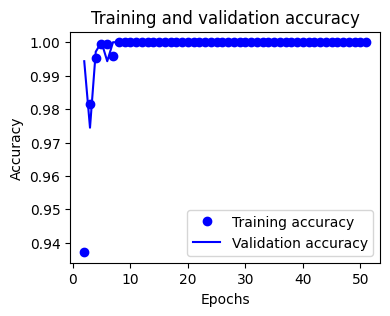

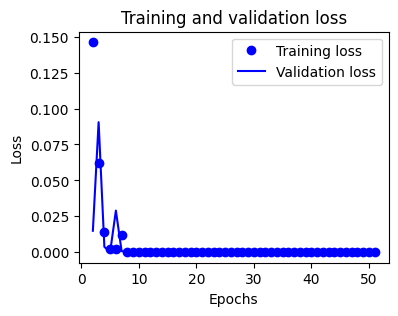

In [ ]:
import matplotlib.pyplot as plt
# Define height and width
height = 3
width = 4
font = {'family': 'Times New Roman',  'size': 12}
# Create the plot with specified height and width
plt.figure(figsize=(width, height))
# Plot training and validation accuracy
plt.plot(epochs, acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
# Show the plot
plt.show()
# Create another plot for training and validation loss
plt.figure(figsize=(width, height))
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss')

# Show the plot
plt.show()

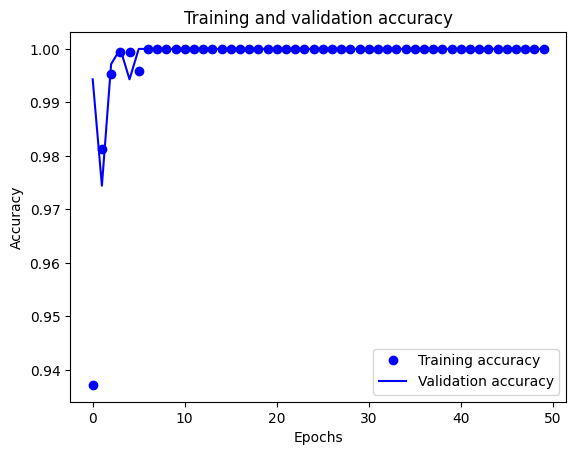

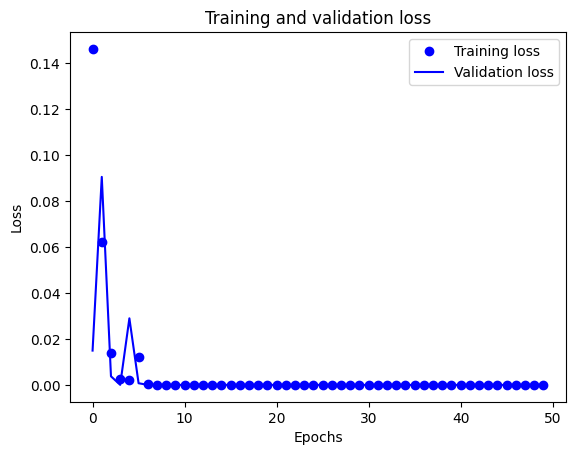

In [ ]:
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(accuracy))
plt.plot(epochs, accuracy, 'bo', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

In [ ]:
prediction_NN = model.predict(x_test)
prediction_NN = np.argmax(prediction_NN, axis=1)
prediction_NN = le.inverse_transform(prediction_NN)

28/28 [==============================] - 8s 113ms/step


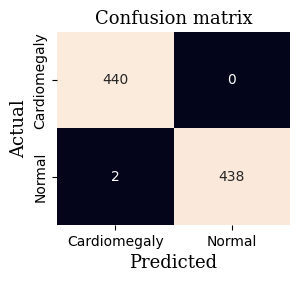

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
# Define font family and fontsize
font = {'family': 'serif',  'size': 13}
#font = {'family': 'serif', 'weight': 'bold', 'size': 14}
# Classes
nClasses = ['Cardiomegaly','Normal']
# Confusion Matrix
plt.figure(figsize=(3, 2.5))
cm = confusion_matrix(test_labels, prediction_NN)
sns.heatmap(cm, cbar=False, xticklabels=nClasses, yticklabels=nClasses, fmt='d', annot=True)
plt.title('Confusion matrix', fontdict=font)
plt.xlabel(r'Predicted', fontdict=font)
plt.ylabel(r'Actual', fontdict=font)
plt.show()

In [ ]:
from sklearn.metrics import classification_report
#target_names = ["Class {}".format(i) for i in range(num_classes)]
print(classification_report(test_labels, prediction_NN, target_names=['Cardiomegaly (Class 0)','Normal (Class 1)']))

                        precision    recall  f1-score   support

Cardiomegaly (Class 0)       1.00      1.00      1.00       440
      Normal (Class 1)       1.00      1.00      1.00       440

              accuracy                           1.00       880
             macro avg       1.00      1.00      1.00       880
          weighted avg       1.00      1.00      1.00       880



In [ ]:
predicted_classes = model.predict(x_test)

13/13 [==============================] - 1s 49ms/step


In [ ]:
predicted_classes = np.argmax(np.round(predicted_classes),axis=1)
predicted_classes.shape, y_test.shape

((400,), (400,))

Found 389 correct labels


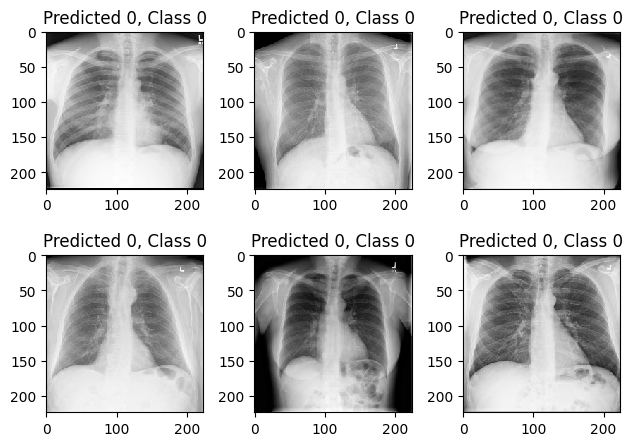

In [ ]:
correct = np.where(predicted_classes==y_test)[0]
print ("Found %d correct labels" % len(correct))
for i, correct in enumerate(correct[:6]):
    plt.subplot(2,3,i+1)
    plt.imshow(x_test[correct], cmap='gray', interpolation='none')
    plt.title("Predicted {}, Class {}".format(predicted_classes[correct], y_test[correct]))
    plt.tight_layout()

Found 11 incorrect labels


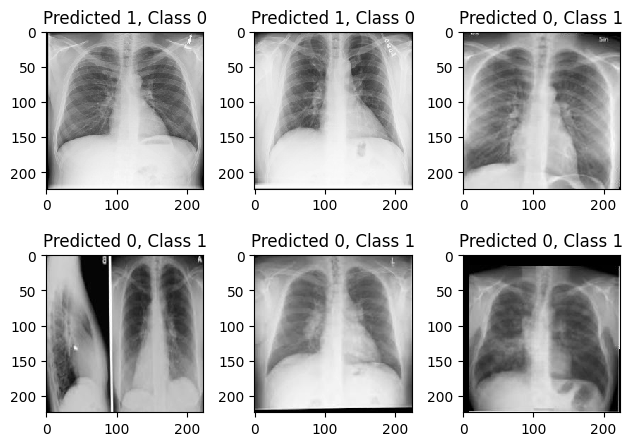

In [ ]:
incorrect = np.where(predicted_classes!=y_test)[0]
print ("Found %d incorrect labels" % len(incorrect))
for i, incorrect in enumerate(incorrect[:6]):
    plt.subplot(2,3,i+1)
    plt.imshow(x_test[incorrect], cmap='gray', interpolation='none')
    plt.title("Predicted {}, Class {}".format(predicted_classes[incorrect], y_test[incorrect]))
    plt.tight_layout()

1/1 [==============================] - 1s 546ms/step
The prediction for this image is:  ['Normal']
The actual label for this image is:  Normal


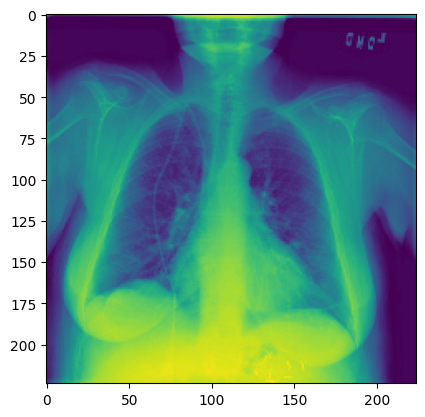

In [ ]:
#Check results on a few select images
n=19  #Select the index of image to be loaded for testing
img = x_test[n]
plt.imshow(img)
input_img = np.expand_dims(img, axis=0) #Expand dims so the input is (num images, x, y, c)
prediction = np.argmax(model.predict(input_img))  #argmax to convert categorical back to original
prediction = le.inverse_transform([prediction])  #Reverse the label encoder to original name
print("The prediction for this image is: ", prediction)
print("The actual label for this image is: ", test_labels[n])

# Features from convolutional network for RF and SVM

In [ ]:
#Now, let us use features from convolutional network for RF
X_for_RF = model.predict(x_train) #This is out X input to RF

50/50 [==============================] - 2s 45ms/step


# RANDOM FOREST

In [ ]:
from sklearn.ensemble import RandomForestClassifier
RF_model = RandomForestClassifier(n_estimators = 50, random_state = 42)

In [ ]:
# Train the model on training data
RF_model.fit(X_for_RF, y_train) #For sklearn no one hot encoding

RandomForestClassifier(n_estimators=50, random_state=42)

In [ ]:
#Send test data through same feature extractor process
X_test_feature = model.predict(x_test)
#Now predict using the trained RF model.
prediction_RF = RF_model.predict(X_test_feature)
#Inverse le transform to get original label back.
prediction_RF = le.inverse_transform(prediction_RF)

13/13 [==============================] - 1s 49ms/step


In [ ]:
#Print overall accuracy
from sklearn import metrics
print ("Accuracy = ", metrics.accuracy_score(test_labels, prediction_RF))

Accuracy =  0.975


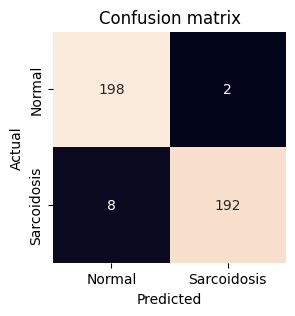

In [ ]:
#Confusion Matrix - verify accuracy of each class
from sklearn.metrics import confusion_matrix
classes = ['Normal', 'Sarcoidosis']
plt.figure(figsize=(3,3))
cm = confusion_matrix(test_labels, prediction_RF)
plt.title('Confusion matrix')
#sns.heatmap(cm, annot=True)
#sns.heatmap(cm, cbar=False, xticklabels=classes, yticklabels=classes, fmt='d', annot=True, cmap=plt.cm.Blues)
sns.heatmap(cm, cbar=False, xticklabels=classes, yticklabels=classes, fmt='d', annot=True)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [ ]:
from sklearn.metrics import classification_report
#target_names = ["Class {}".format(i) for i in range(num_classes)]

print(classification_report(test_labels, prediction_NN, target_names=['Normal (Class 0)','Sarcoidosis (Class 1)']))

                       precision    recall  f1-score   support

     Normal (Class 0)       0.96      0.99      0.97       200
Sarcoidosis (Class 1)       0.99      0.95      0.97       200

             accuracy                           0.97       400
            macro avg       0.97      0.97      0.97       400
         weighted avg       0.97      0.97      0.97       400



# SVM with CNN

# 1. Linear SVM

In [ ]:
from sklearn.svm import  SVC
from sklearn.svm import LinearSVC
svclassifier = SVC(kernel='linear', degree=8)
#model = LinearSVC(max_iter=100)  #Default of 100 is not converging

In [ ]:
from sklearn.svm import SVC
svclassifier = SVC(kernel='linear', degree=8)
svclassifier.fit(X_for_RF, y_train)

SVC(degree=8, kernel='linear')

In [ ]:
X_test_feature = model.predict(x_test)
prediction_SVC = svclassifier.predict(X_test_feature)
prediction_SVC = le.inverse_transform(prediction_SVC)

13/13 [==============================] - 1s 47ms/step


In [ ]:
#Print overall accuracy
from sklearn import metrics
print ("Accuracy = ", metrics.accuracy_score(test_labels, prediction_SVC))


Accuracy =  0.975


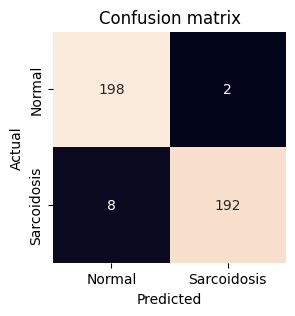

In [ ]:
#Confusion Matrix - verify accuracy of each class
from sklearn.metrics import confusion_matrix
classes = ['Normal', 'Sarcoidosis']
plt.figure(figsize=(3,3))
cm = confusion_matrix(test_labels, prediction_SVC)
plt.title('Confusion matrix')
#sns.heatmap(cm, annot=True)
#sns.heatmap(cm, cbar=False, xticklabels=classes, yticklabels=classes, fmt='d', annot=True, cmap=plt.cm.Blues)
sns.heatmap(cm, cbar=False, xticklabels=classes, yticklabels=classes, fmt='d', annot=True)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [ ]:
from sklearn.metrics import classification_report
#target_names = ["Class {}".format(i) for i in range(num_classes)]

print(classification_report(test_labels, prediction_NN, target_names=['Normal (Class 0)','Sarcoidosis (Class 1)']))

                       precision    recall  f1-score   support

     Normal (Class 0)       0.96      0.99      0.97       200
Sarcoidosis (Class 1)       0.99      0.95      0.97       200

             accuracy                           0.97       400
            macro avg       0.97      0.97      0.97       400
         weighted avg       0.97      0.97      0.97       400



# 2. Gaussian Kernel- rbf

In [ ]:
from sklearn.svm import SVC
svclassifier = SVC(kernel='rbf', degree=8)
svclassifier.fit(X_for_RF, y_train)

SVC(degree=8)

In [ ]:
prediction_SVC = svclassifier.predict(X_test_feature)
prediction_SVC = le.inverse_transform(prediction_SVC)

In [ ]:
#Print overall accuracy
from sklearn import metrics
print ("Accuracy = ", metrics.accuracy_score(test_labels, prediction_SVC))


Accuracy =  0.975


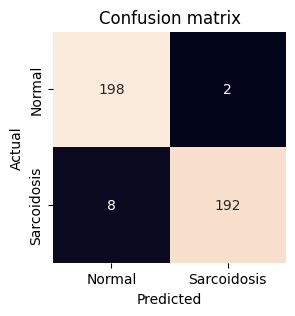

In [ ]:
#Confusion Matrix - verify accuracy of each class
from sklearn.metrics import confusion_matrix
classes = ['Normal', 'Sarcoidosis']
plt.figure(figsize=(3,3))
cm = confusion_matrix(test_labels, prediction_SVC)
plt.title('Confusion matrix')
#sns.heatmap(cm, annot=True)
#sns.heatmap(cm, cbar=False, xticklabels=classes, yticklabels=classes, fmt='d', annot=True, cmap=plt.cm.Blues)
sns.heatmap(cm, cbar=False, xticklabels=classes, yticklabels=classes, fmt='d', annot=True)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [ ]:
from sklearn.metrics import classification_report
#target_names = ["Class {}".format(i) for i in range(num_classes)]

print(classification_report(test_labels, prediction_NN, target_names=['Normal (Class 0)','Sarcoidosis (Class 1)']))

                       precision    recall  f1-score   support

     Normal (Class 0)       0.96      0.99      0.97       200
Sarcoidosis (Class 1)       0.99      0.95      0.97       200

             accuracy                           0.97       400
            macro avg       0.97      0.97      0.97       400
         weighted avg       0.97      0.97      0.97       400



# 3. Polynomial Kernel SVM

In [ ]:
from sklearn.svm import SVC
svclassifier = SVC(kernel='poly', degree=8)
svclassifier.fit(X_for_RF, y_train)

SVC(degree=8, kernel='poly')

In [ ]:
prediction_SVC = svclassifier.predict(X_test_feature)
prediction_SVC = le.inverse_transform(prediction_SVC)

In [ ]:
#Print overall accuracy
from sklearn import metrics
print ("Accuracy = ", metrics.accuracy_score(test_labels, prediction_SVC))


Accuracy =  0.975


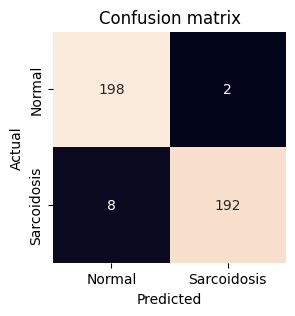

In [ ]:
#Confusion Matrix - verify accuracy of each class
from sklearn.metrics import confusion_matrix
classes = ['Normal', 'Sarcoidosis']
plt.figure(figsize=(3,3))
cm = confusion_matrix(test_labels, prediction_SVC)
plt.title('Confusion matrix')
#sns.heatmap(cm, annot=True)
#sns.heatmap(cm, cbar=False, xticklabels=classes, yticklabels=classes, fmt='d', annot=True, cmap=plt.cm.Blues)
sns.heatmap(cm, cbar=False, xticklabels=classes, yticklabels=classes, fmt='d', annot=True)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [ ]:
from sklearn.metrics import classification_report
#target_names = ["Class {}".format(i) for i in range(num_classes)]

print(classification_report(test_labels, prediction_NN, target_names=['Normal (Class 0)','Sarcoidosis (Class 1)']))

                       precision    recall  f1-score   support

     Normal (Class 0)       0.96      0.99      0.97       200
Sarcoidosis (Class 1)       0.99      0.95      0.97       200

             accuracy                           0.97       400
            macro avg       0.97      0.97      0.97       400
         weighted avg       0.97      0.97      0.97       400



# 4. Sigmoid

In [ ]:
from sklearn.svm import SVC
svcmodel = SVC(kernel='sigmoid', degree=8)
svcmodel.fit(X_for_RF, y_train)

SVC(degree=8, kernel='sigmoid')

In [ ]:
prediction_SVC = svcmodel.predict(X_test_feature)
prediction_SVC = le.inverse_transform(prediction_SVC)
#Print overall accuracy
from sklearn import metrics
print ("Accuracy = ", metrics.accuracy_score(test_labels, prediction_SVC))


Accuracy =  0.9725


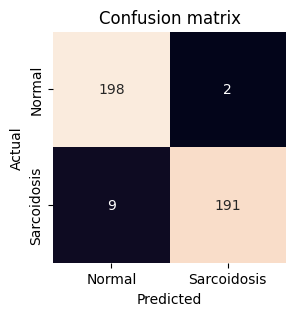

In [ ]:
#Confusion Matrix - verify accuracy of each class
from sklearn.metrics import confusion_matrix
classes = ['Normal', 'Sarcoidosis']
plt.figure(figsize=(3,3))
cm = confusion_matrix(test_labels, prediction_SVC)
plt.title('Confusion matrix')
#sns.heatmap(cm, annot=True)
#sns.heatmap(cm, cbar=False, xticklabels=classes, yticklabels=classes, fmt='d', annot=True, cmap=plt.cm.Blues)
sns.heatmap(cm, cbar=False, xticklabels=classes, yticklabels=classes, fmt='d', annot=True)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [ ]:
from sklearn.metrics import classification_report
#target_names = ["Class {}".format(i) for i in range(num_classes)]

print(classification_report(test_labels, prediction_NN, target_names=['Normal (Class 0)','Sarcoidosis (Class 1)']))

                       precision    recall  f1-score   support

     Normal (Class 0)       0.96      0.99      0.97       200
Sarcoidosis (Class 1)       0.99      0.95      0.97       200

             accuracy                           0.97       400
            macro avg       0.97      0.97      0.97       400
         weighted avg       0.97      0.97      0.97       400

